<a href="https://colab.research.google.com/github/MaximeSzymanski/GraphDeepQNetwork/blob/main/GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import networkx as nx
import pprint as pp
import torch
import torch.nn as nn
import torch.nn.functional as F
import  gymnasium as gym
import torch.optim as optim
import matplotlib.pyplot as plt


In [ ]:
# create a grid graph
WIDTH = 4
HEIGHT = 4
G = nx.grid_2d_graph(WIDTH, HEIGHT)

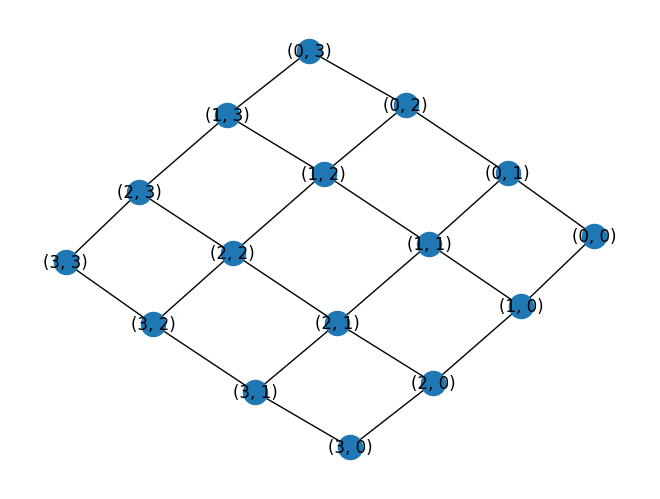

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
adj = nx.adjacency_matrix(G).todense()
pp.pprint(adj)

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])


In [ ]:

# build the sum of the adjency matrix and the identity matrix, with power
def build_transition_matrix(adj, power):
    adj = adj + np.identity(adj.shape[0])
    for i in range(power-1):
        adj = np.matmul(adj, adj)
    return adj

In [ ]:
print(build_transition_matrix(adj, 2))

[[3. 2. 1. 0. 2. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [2. 4. 2. 1. 2. 2. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 2. 4. 2. 0. 2. 2. 2. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0. 0. 2. 2. 0. 0. 0. 1. 0. 0. 0. 0.]
 [2. 2. 0. 0. 4. 2. 1. 0. 2. 2. 0. 0. 1. 0. 0. 0.]
 [2. 2. 2. 0. 2. 5. 2. 1. 2. 2. 2. 0. 0. 1. 0. 0.]
 [0. 2. 2. 2. 1. 2. 5. 2. 0. 2. 2. 2. 0. 0. 1. 0.]
 [0. 0. 2. 2. 0. 1. 2. 4. 0. 0. 2. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 2. 0. 0. 4. 2. 1. 0. 2. 2. 0. 0.]
 [0. 1. 0. 0. 2. 2. 2. 0. 2. 5. 2. 1. 2. 2. 2. 0.]
 [0. 0. 1. 0. 0. 2. 2. 2. 1. 2. 5. 2. 0. 2. 2. 2.]
 [0. 0. 0. 1. 0. 0. 2. 2. 0. 1. 2. 4. 0. 0. 2. 2.]
 [0. 0. 0. 0. 1. 0. 0. 0. 2. 2. 0. 0. 3. 2. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 2. 0. 2. 4. 2. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 2. 1. 2. 4. 2.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 0. 1. 2. 3.]]


In [ ]:
number_thief = 1
number_cop = 1
number_nodes = WIDTH * HEIGHT
number_actions = 4
number_states = number_nodes
# get a random position for the thief (x, y)
thief_position = (np.random.randint(0, WIDTH), np.random.randint(0, HEIGHT))

# get a random position for the cop
cop_position = (np.random.randint(0, WIDTH), np.random.randint(0, HEIGHT))

In [ ]:
print(f"thief_position : {thief_position}")
print(f"cop_position : {cop_position}")

thief_position : (0, 1)
cop_position : (1, 1)


In [ ]:
def initialize_state(thief_position : tuple, cop_position : tuple, graph: nx.Graph):
    for node in graph.nodes():
        graph.nodes[node]["agent"] = 0

    graph.nodes[thief_position]["agent"] = 1
    graph.nodes[cop_position]["agent"] = 2

    return graph
def plot_graph(graph):
    # plot thief in red, cop in blue
    node_colors = []
    for node in graph.nodes():
        if graph.nodes[node]["agent"] == 1:
            node_colors.append("red")
        elif graph.nodes[node]["agent"] == 2:
            node_colors.append("blue")
        else:
            node_colors.append("green")
    pos = {(i, j): (i, -j) for i, j in graph.nodes()}  # Specify positions for nodes
    plt.figure(figsize=(5, 5))  # Set the size of the plot
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
    plt.title('Grid Graph', fontsize=12)
    plt.show()


In [ ]:
G = initialize_state(thief_position, cop_position, G)
#plot_graph(G)

In [ ]:
def adjency_matrix_to_mask(adj):
    mask = np.zeros(adj.shape)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i, j] > 0:
                mask[i, j] = 0
            else:
                mask[i, j] = -np.inf
    return mask

In [ ]:
trans_mat = build_transition_matrix(adj, 2)
print(trans_mat)
print(adjency_matrix_to_mask(trans_mat))

[[3. 2. 1. 0. 2. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [2. 4. 2. 1. 2. 2. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 2. 4. 2. 0. 2. 2. 2. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0. 0. 2. 2. 0. 0. 0. 1. 0. 0. 0. 0.]
 [2. 2. 0. 0. 4. 2. 1. 0. 2. 2. 0. 0. 1. 0. 0. 0.]
 [2. 2. 2. 0. 2. 5. 2. 1. 2. 2. 2. 0. 0. 1. 0. 0.]
 [0. 2. 2. 2. 1. 2. 5. 2. 0. 2. 2. 2. 0. 0. 1. 0.]
 [0. 0. 2. 2. 0. 1. 2. 4. 0. 0. 2. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 2. 0. 0. 4. 2. 1. 0. 2. 2. 0. 0.]
 [0. 1. 0. 0. 2. 2. 2. 0. 2. 5. 2. 1. 2. 2. 2. 0.]
 [0. 0. 1. 0. 0. 2. 2. 2. 1. 2. 5. 2. 0. 2. 2. 2.]
 [0. 0. 0. 1. 0. 0. 2. 2. 0. 1. 2. 4. 0. 0. 2. 2.]
 [0. 0. 0. 0. 1. 0. 0. 0. 2. 2. 0. 0. 3. 2. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 2. 0. 2. 4. 2. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 2. 1. 2. 4. 2.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 0. 1. 2. 3.]]
[[  0.   0.   0. -inf   0.   0. -inf -inf   0. -inf -inf -inf -inf -inf
  -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0. -inf -inf   0. -inf -inf -inf -inf
  -inf -inf]
 [  0.   0.  

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self,embedding_dim,head_num,masked=False,device="cpu"):
        super(MultiHeadAttention,self).__init__()
        self.embedding_dim = embedding_dim
        self.head_num = head_num

        self.device=device

        print(f"device {self.device}")
        self.masked = masked
        #assert embedding_dim % head_num == 0 , "embedding_dim must be divisible by head_num"
        assert head_num > 0 , "head_num must be greater than 0"

        self.head_dim = 64 // head_num

        self.fc_Q = nn.Linear(self.embedding_dim,64)
        self.fc_K = nn.Linear(self.embedding_dim,64)
        self.fc_V = nn.Linear(self.embedding_dim,64)
        self.uni_head = nn.Linear(self.head_num * self.head_dim,self.embedding_dim)


    def forward(self,x,mask_matrix):
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        Q = self.fc_Q(x)
        K = self.fc_K(x)
        V = self.fc_V(x)

        # split heads
        Q = Q.view(batch_size,seq_len,self.head_num,self.head_dim)
        K = K.view(batch_size,seq_len,self.head_num,self.head_dim)
        V = V.view(batch_size,seq_len,self.head_num,self.head_dim)

        Q  = Q.view(batch_size * self.head_num,seq_len,self.head_dim)
        K  = K.view(batch_size * self.head_num,seq_len,self.head_dim)
        V  = V.view(batch_size * self.head_num,seq_len,self.head_dim)


        # attention

        dot_product = torch.bmm(Q,K.transpose(1,2))
        mask_matrix = torch.tensor(mask_matrix,dtype=torch.float32,device=self.device)
        #duplicate mask for each head

        mask_matrix = mask_matrix.repeat(self.head_num*batch_size,1,1)

        dot_product = dot_product + mask_matrix
        dot_product = dot_product / np.sqrt(self.head_dim)
        dot_product = F.softmax(dot_product,dim=2)

        attention = torch.bmm(dot_product,V)
        if self.masked:
            # get a 0 under the diagonal, and -inf everywhere else
            mask = torch.triu(torch.full((seq_len,seq_len), float('-inf')), diagonal=1)
            # apply mask to scores
            attention += mask

        attention  = attention.view(batch_size , self.head_num,seq_len,self.head_dim)
        attention = attention.view(batch_size,seq_len,self.head_num * self.head_dim)
        # concat heads

        return self.uni_head(attention)

In [ ]:
# generate random tensor size (2,10,2)
x = torch.rand(2,4,4)
masked_matrix = np.zeros((4,4))
masked_matrix[0,1] = -np.inf

print(f'masked_matrix : {masked_matrix}')
model = MultiHeadAttention(4,2)
x = model(x,masked_matrix)


masked_matrix : [[  0. -inf   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]]
device cpu


In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim,head_num,device="cpu"):
        super(TransformerEncoderBlock,self).__init__()
        print(f"device 2 {device}")
        self.multi_head_attention = MultiHeadAttention(embedding_dim,head_num,device=device)
        self.multi_head_attention.to(device)
        self.fc = nn.Linear(embedding_dim,embedding_dim)
        self.fc.to(device)
        self.norm = nn.LayerNorm(embedding_dim)
        self.norm.to(device)

    def forward(self,x,mask_matrix):

        attention = self.multi_head_attention(x,mask_matrix)
        x = attention + x

        #x = self.norm(x)
        fully_connected = self.fc(x)

        x = fully_connected + x
        #x = self.norm(x)

        return x

In [ ]:
class actor_graph_attention(nn.Module):
    def __init__(self,embedding_dim,head_num,action_dim,node_graph_dim):
        super(actor_graph_attention,self).__init__()
        self.embedding_dim = embedding_dim
        self.head_num = head_num
        self.transformer_encoder = TransformerEncoderBlock(embedding_dim,head_num)
        self.fc = nn.Linear(embedding_dim*node_graph_dim,action_dim)

    def forward(self,x,mask_matrix):
        x = self.transformer_encoder(x,mask_matrix)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

class critic_graph_attention(nn.Module):
    def __init__(self,embedding_dim,head_num,node_graph_dim):
        super(critic_graph_attention,self).__init__()
        self.embedding_dim = embedding_dim
        self.head_num = head_num
        self.transformer_encoder = TransformerEncoderBlock(embedding_dim,head_num)
        self.fc = nn.Linear(embedding_dim*node_graph_dim,1)

    def forward(self,x,mask_matrix):
        x = self.transformer_encoder(x,mask_matrix)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

class q_network_graph_attention(nn.Module):
    def __init__(self,embedding_dim,head_num,node_graph_dim,action_dim,device="cpu"):
        super(q_network_graph_attention,self).__init__()
        self.embedding_dim = embedding_dim

        self.head_num = head_num
        self.transformer_encoder = TransformerEncoderBlock(embedding_dim,head_num,device=device)
        self.transformer_encoder.to(device)
        self.fc1 = nn.Linear(embedding_dim*node_graph_dim+action_dim,128)
        self.fc1.to(device)
        self.fc2 = nn.Linear(128,1)
        self.fc2.to(device)

    def forward(self,x,mask_matrix,action):
        x = self.transformer_encoder(x,mask_matrix)
        x = x.view(x.shape[0],-1)
        x = torch.cat((x,action),dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
def get_node_features(graph ):
    node_features = np.zeros((len(graph.nodes()), 1))
    index = 0
    for node in graph.nodes():
        node_features[index] = graph.nodes[node]["agent"]
        index += 1
    return node_features

In [ ]:
node_features = get_node_features(G)
# create a random matrix with same size as node_features
dummy_node = np.random.rand(node_features.shape[0],node_features.shape[1])
masked_matrix = adjency_matrix_to_mask(nx.adjacency_matrix(G).todense())
transformer_encoder = TransformerEncoderBlock(1,1)
x = torch.tensor(node_features,dtype=torch.float32,requires_grad=False)
x = x.unsqueeze(0)
y = torch.tensor(dummy_node,dtype=torch.float32,requires_grad=False)
y = y.unsqueeze(0)
# create a batch  with x and y, size (2,10,1)
z = torch.cat((x,y),dim=0)
print(z.shape)

device 2 cpu
device cpu
torch.Size([2, 16, 1])


In [ ]:
actor = actor_graph_attention(1,1,4,WIDTH*HEIGHT)
critic = critic_graph_attention(1,1,WIDTH*HEIGHT)
action  = actor(z,masked_matrix)
value = critic(z,masked_matrix)
print(action)
print(value)

device 2 cpu
device cpu
device 2 cpu
device cpu
tensor([[0.7974, 1.2022, 0.7844, 0.5005],
        [0.5638, 1.1140, 0.6112, 0.5685]], grad_fn=<AddmmBackward0>)
tensor([[-0.0515],
        [ 0.9279]], grad_fn=<AddmmBackward0>)


In [ ]:
import gymnasium.spaces as spaces
class GridWorld_copsVSthief(gym.Env):
    def __init__(self,WIDTH,HEIGHT):
        grid_graph = nx.grid_2d_graph(WIDTH,HEIGHT)
        self.G = grid_graph
        self.WIDTH = WIDTH
        self.HEIGHT = HEIGHT

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=1, shape=(WIDTH,HEIGHT,1), dtype=np.float32)

    def reset(self):
        self.thief_position = (np.random.randint(0,self.WIDTH),np.random.randint(0,self.HEIGHT))
        self.cops_position = (np.random.randint(0,self.WIDTH),np.random.randint(0,self.HEIGHT))

        self.G = initialize_state(self.thief_position,self.cops_position,self.G)

        adj = nx.adjacency_matrix(self.G).todense()

        self.state = get_node_features(self.G),adjency_matrix_to_mask( build_transition_matrix(adj,2))
        return self.state

    def step(self,action):
        # 0 : up
        # 1 : right
        # 2 : down
        # 3 : left
        # 4 : stay



        if action == 0:
            # check if the thief is at the border
            if self.thief_position[1] == self.HEIGHT-1:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
            else:
                self.thief_position = (self.thief_position[0],(self.thief_position[1]+1)%self.HEIGHT)
        elif action == 1:
            if self.thief_position[0] == self.WIDTH-1:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
            else:
                self.thief_position = ((self.thief_position[0]+1)%self.WIDTH,self.thief_position[1])
        elif action == 2:
            # check if the thief is at the border
            if self.thief_position[1] == 0:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
            else:
                self.thief_position = (self.thief_position[0],(self.thief_position[1]-1)%self.HEIGHT)
        elif action == 3:
            # check if the thief is at the border
            if self.thief_position[0] == 0:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
            else:
                self.thief_position = ((self.thief_position[0]-1)%self.WIDTH,self.thief_position[1])
        elif action == 4:
            pass

        # reward is the distance between cops and thief, the closer the better

        reward = -np.sqrt((self.thief_position[0]-self.cops_position[0])**2+(self.thief_position[1]-self.cops_position[1])**2)
        self.G = initialize_state(self.thief_position,self.cops_position,self.G)

        adj = nx.adjacency_matrix(self.G).todense()


        self.state = get_node_features(self.G),adjency_matrix_to_mask( build_transition_matrix(adj,2))
        info = {}
        done = self.thief_position == self.cops_position

        if done:
            reward = 100
        return self.state,reward, _, _,info,done

    def render(self):
        plot_graph(self.G)
    def close(self):
        pass


(array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), array([[  0.,   0.,   0., -inf, -inf,   0.,   0., -inf, -inf, -inf,   0.,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf],
       [  0.,   0.,   0.,   0., -inf,   0.,   0.,   0., -inf, -inf, -inf,
          0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf],
       [  0.,   0.,   0.,   0.,   0., -inf,   0.,   0.,   0., -inf, -inf,
        -inf,   0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf],
       [-inf,   0.,   0.,   0.,   0., -inf, -inf,   0.,   0.,   0., -inf,
        -inf, -inf,   0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,

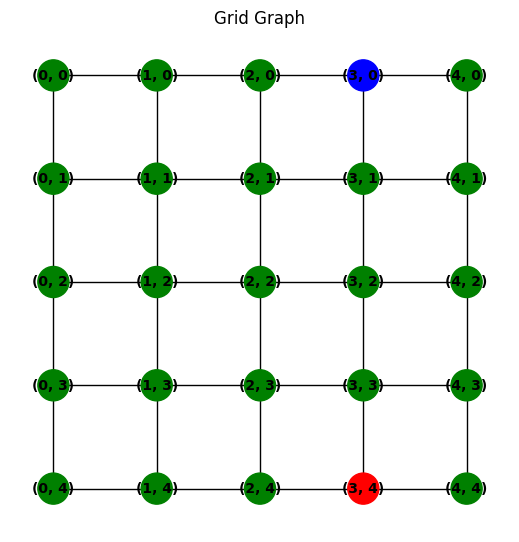

In [ ]:
env = GridWorld_copsVSthief(5,5)
state = env.reset()
print(state)

env.render()

In [ ]:
import random
import torch
import torch.nn as nn
import numpy as np

class DQN():
    def __init__(self, env, device):
        self.device = device
        self.env = env
        self.action_space = 4
        self.observation_space = env.WIDTH * env.HEIGHT
        self.q_network = q_network_graph_attention(1, 8, env.WIDTH * env.HEIGHT, 1,self.device)
        self.q_network.to(self.device)
        self.target_network = q_network_graph_attention(1, 1, env.WIDTH * env.HEIGHT, 1,self.device)
        self.target_network.to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_update_freq = 1000  # Frequency to update target network
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=0.0025)
        self.loss = nn.SmoothL1Loss()  # Huber loss for more robust training
        self.replay_buffer = replay_buffer()
        self.gamma = 0.99
        self.epsilon = 1
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.num_episodes = 100000
        self.update_freq = 2
        self.batch_size = 1024
        self.max_len_episode = 50
        self.loss_list = []
        self.step_counter = 0  # Counter for the number of steps taken so far

    def get_action(self, state, masked_matrix):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        else:
            best_act = -np.inf
            state = torch.tensor(state, dtype=torch.float32, device=self.device)
            state = state.unsqueeze(0)
            with torch.no_grad():
                for i in range(self.action_space):
                    action = torch.tensor([i], dtype=torch.float32, device=self.device)
                    action = action.unsqueeze(0)
                    q_current = self.q_network(state, masked_matrix, action)
                    if q_current > best_act:
                        best_act = q_current
                        best_action = i
            return best_action

    def sample_minibatch(self):
        minibatch = self.replay_buffer.sample(self.batch_size)
        return minibatch

    def train(self):
        for i in range(self.num_episodes):
            state, masked_matrix = self.env.reset()
            done = False
            for i in range(self.max_len_episode):
                action = self.get_action(state, masked_matrix)
                next_state, reward, _, _, _, done = self.env.step(action)
                next_state, next_masked_matrix = next_state
                self.step_counter +=1
                self.replay_buffer.add((action, (state, masked_matrix), (next_state, next_masked_matrix), reward, done))
                state = next_state
                masked_matrix = next_masked_matrix
                if done:
                    break
            if self.step_counter >= self.batch_size and self.step_counter % self.update_freq == 0 :
                self.update()
            # Update target network
            if self.step_counter % self.target_update_freq == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())


    def evaluate(self):
        with torch.no_grad():
            state, masked_matrix = self.env.reset()
            done = False
            env.render()
            for i in range(self.max_len_episode):
                action = self.get_action(state, masked_matrix)
                next_state, reward, _, _, _, done = self.env.step(action)
                next_state, next_masked_matrix = next_state
                state = next_state
                masked_matrix = next_masked_matrix
                print(f"step {i} : {reward}")
                print(f"action : {action}")
                env.render()
                if done:
                    break
            return reward

    def update(self):
        minibatch = self.sample_minibatch()
        total_loss = 0
        for state, next_state, action, reward, done in minibatch:
            state, masked_matrix = state
            next_state, next_masked_matrix = next_state
            next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device)
            next_state = next_state.unsqueeze(0)
            with torch.no_grad():
                if done:
                    target = reward
                else:
                    futur_q_best_action = -np.inf
                    for i in range(self.action_space):
                        action_tensor_i = torch.tensor([i], dtype=torch.float32, device=self.device)
                        action_tensor_i = action_tensor_i.unsqueeze(0)
                        q_value_i = self.target_network(next_state, next_masked_matrix, action_tensor_i)
                        q_value_i = q_value_i.item()  # Convert tensor to scalar value
                        if q_value_i > futur_q_best_action:
                            futur_q_best_action = q_value_i
                            best_action = i

                    best_action = torch.tensor([best_action], dtype=torch.float32, device=self.device)
                    best_action = best_action.unsqueeze(0)
                    target = reward + self.gamma * torch.max(self.target_network(next_state, next_masked_matrix, best_action), dim=1).values
            target = torch.tensor([target], dtype=torch.float32, device=self.device)
            target = target.unsqueeze(0)
            state = torch.tensor(state, dtype=torch.float32, device=self.device)
            state = state.unsqueeze(0)
            action = torch.tensor([action], dtype=torch.float32, device=self.device)
            action = action.unsqueeze(0)
            q_value = self.q_network(state, masked_matrix, action)
            loss = self.loss(q_value, target)
            total_loss += loss

        total_loss = total_loss / self.batch_size
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        self.step_counter += 1
        print(f"step {self.step_counter} : {total_loss}")
        self.loss_list.append(total_loss)
        # Decay exploration epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
class replay_buffer():
    def __init__(self):
        self.action = []
        self.state = []
        self.next_state = []
        self.reward = []
        self.done = []
    def add(self,experience):
        self.action.append(experience[0])
        self.state.append(experience[1])
        self.next_state.append(experience[2])
        self.reward.append(experience[3])
        self.done.append(experience[4])

    def sample(self,batch_size):
        sample = random.sample(list(zip(self.state,self.next_state,self.action,self.reward,self.done)),batch_size)
        return sample
    def __len__(self):
        return len(self.action)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dqn = DQN(env,device=device)
dqn.train()

cpu
device 2 cpu
device cpu
device 2 cpu
device cpu
step 1097 : 3.8796565532684326
step 1109 : 3.9641308784484863
step 1133 : 3.816679000854492
step 1165 : 3.891080379486084
step 1377 : 3.2872307300567627
step 1399 : 3.5056169033050537
step 1711 : 3.265458345413208
step 1715 : 3.117088794708252
step 1803 : 2.8585610389709473
step 2041 : 3.0603179931640625
step 2051 : 2.677694082260132
step 2089 : 2.289418935775757
step 2105 : 2.5198616981506348
step 2369 : 2.6706008911132812
step 2467 : 2.2815091609954834
step 2597 : 2.339651346206665
step 2669 : 2.457062005996704
step 2727 : 2.8200762271881104
step 2783 : 2.7172272205352783
step 2851 : 2.7607486248016357
step 2919 : 2.9438281059265137
step 3351 : 2.353588581085205
step 3701 : 2.284513235092163
step 3823 : 1.524271011352539
step 3915 : 2.1165785789489746
step 3957 : 2.1136674880981445
step 4059 : 2.5897927284240723
step 4111 : 1.8017578125
step 4253 : 2.335301160812378
step 4395 : 2.0740623474121094
step 4447 : 1.7981854677200317
step 

KeyboardInterrupt: 

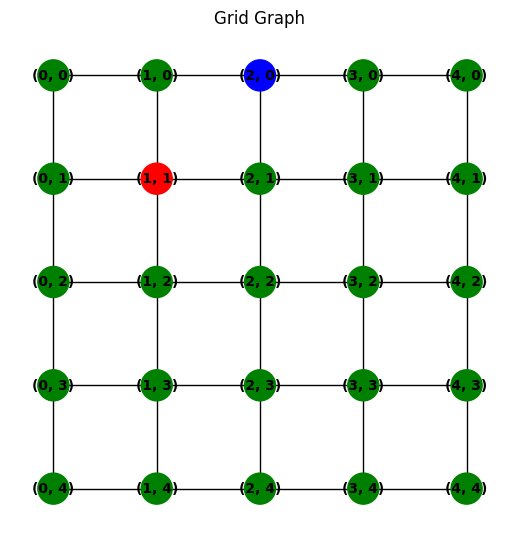

step 0 : -1.0
action : 1


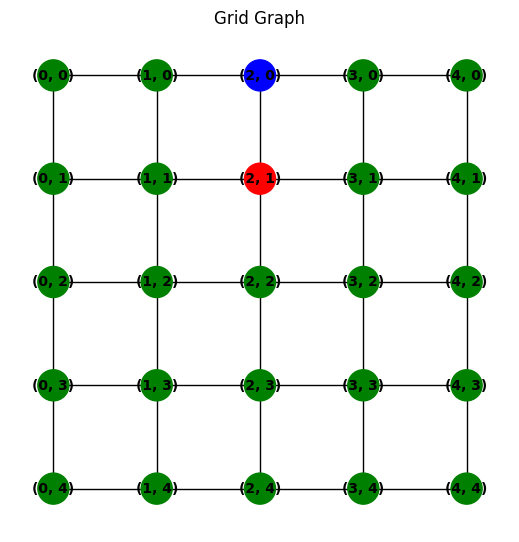

step 1 : -1.4142135623730951
action : 1


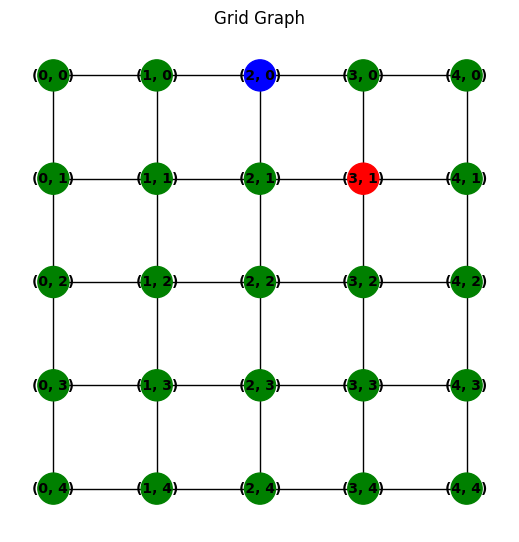

step 2 : -1.0
action : 2


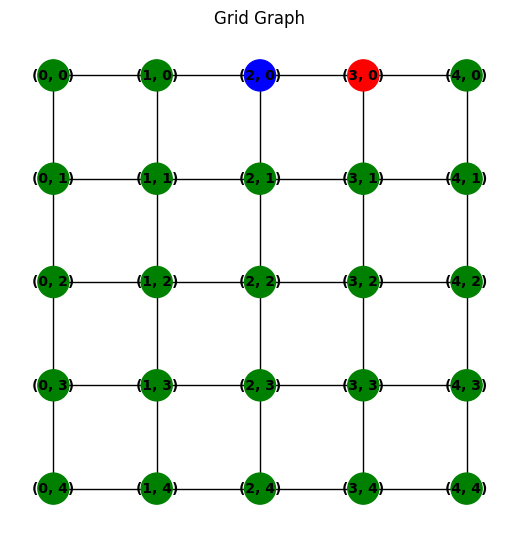

step 3 : -1.0
action : 2


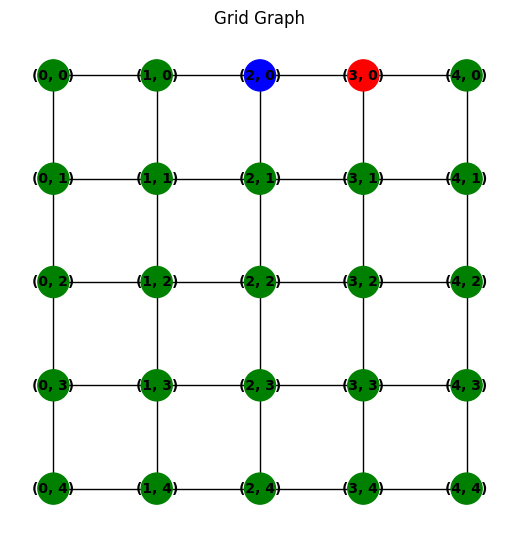

step 4 : -2.0
action : 1


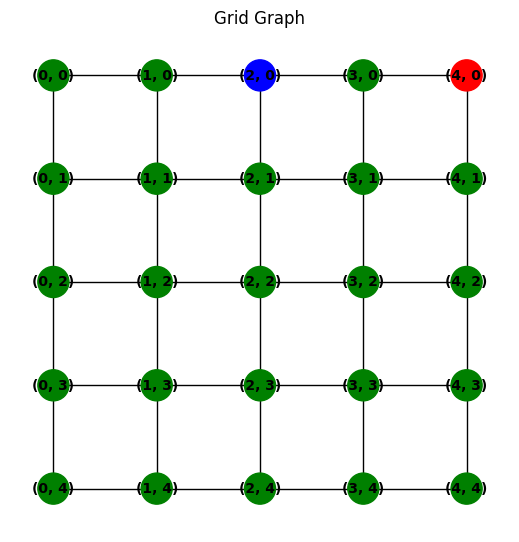

step 5 : -2.0
action : 2


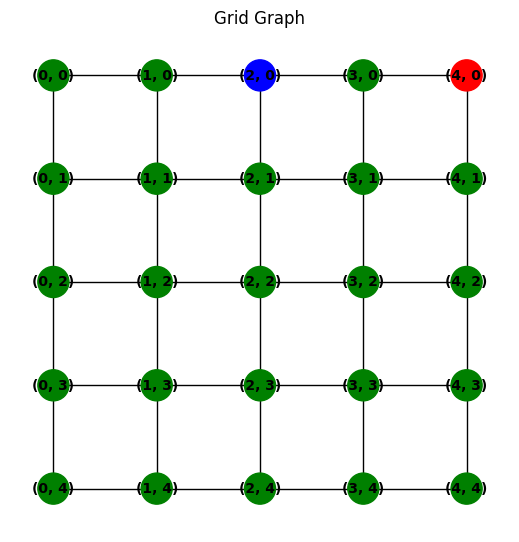

step 6 : -2.0
action : 2


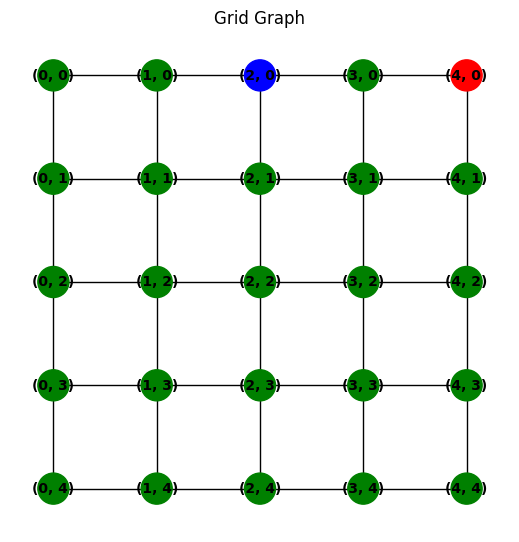

step 7 : -2.0
action : 2


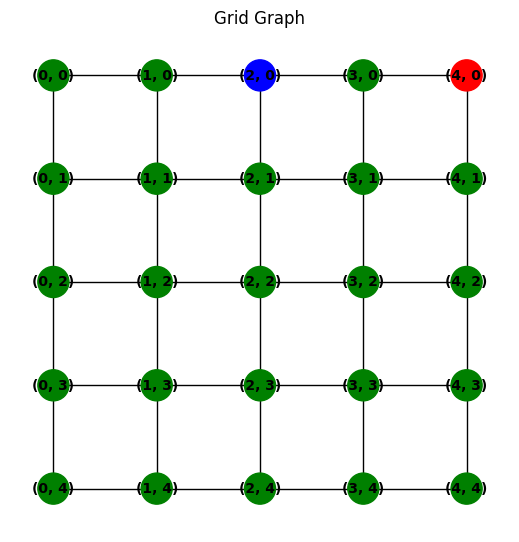

step 8 : -2.23606797749979
action : 0


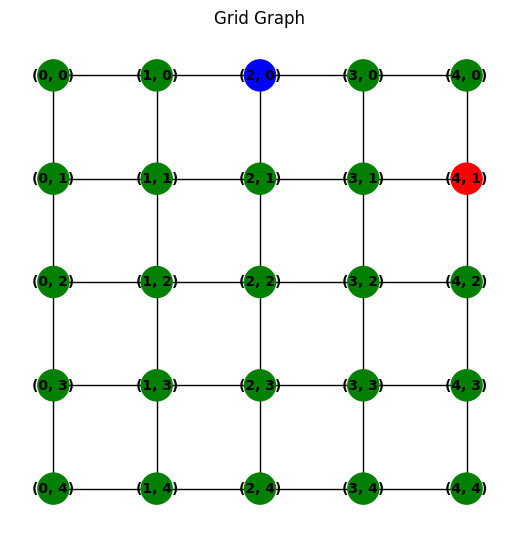

step 9 : -2.8284271247461903
action : 0


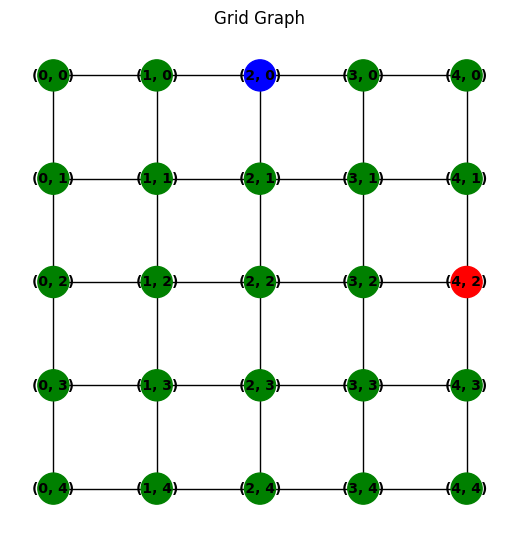

step 10 : -3.605551275463989
action : 0


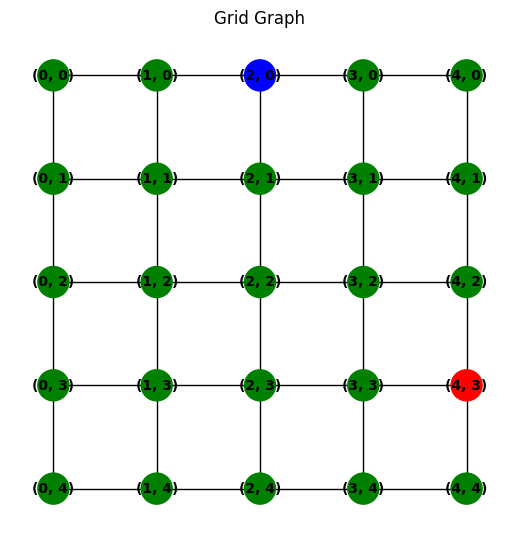

step 11 : -2.8284271247461903
action : 2


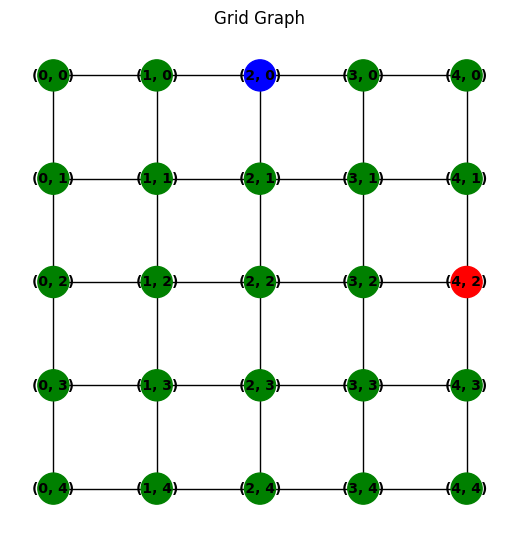

step 12 : -2.23606797749979
action : 3


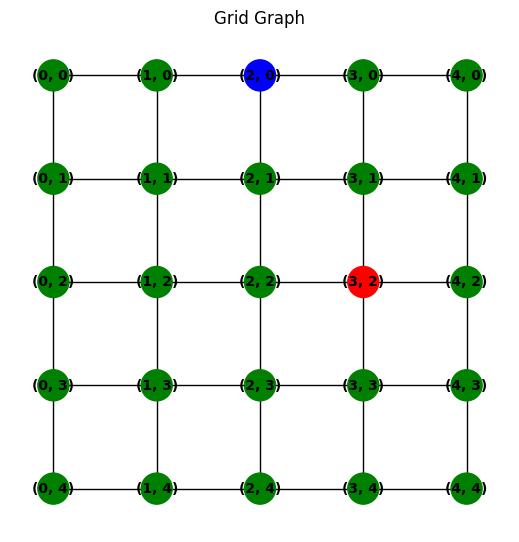

step 13 : -2.8284271247461903
action : 1


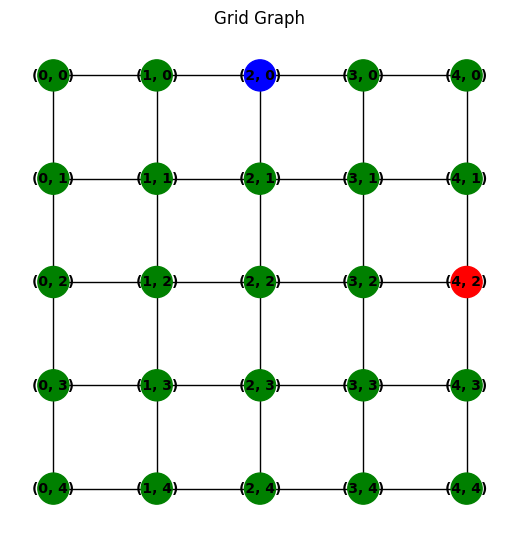

step 14 : -2.23606797749979
action : 3


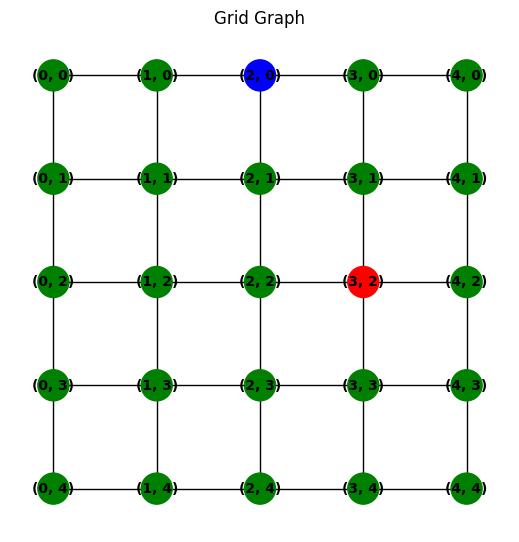

step 15 : -1.4142135623730951
action : 2


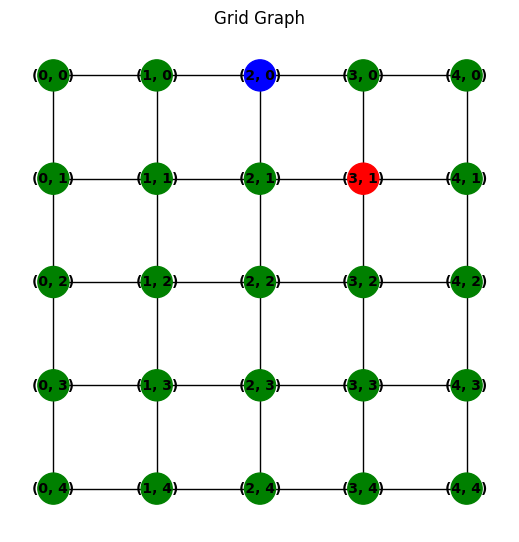

step 16 : -2.23606797749979
action : 0


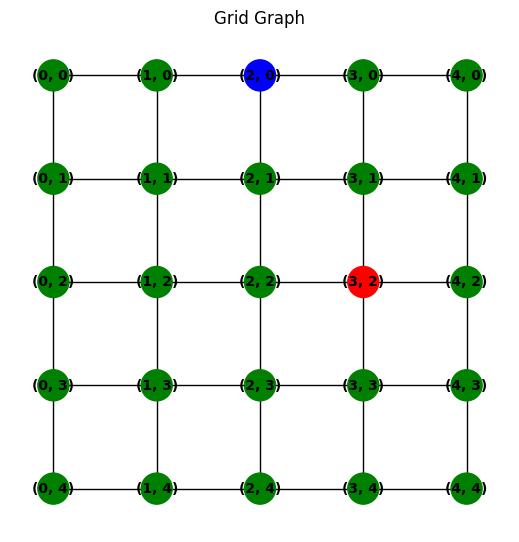

step 17 : -1.4142135623730951
action : 2


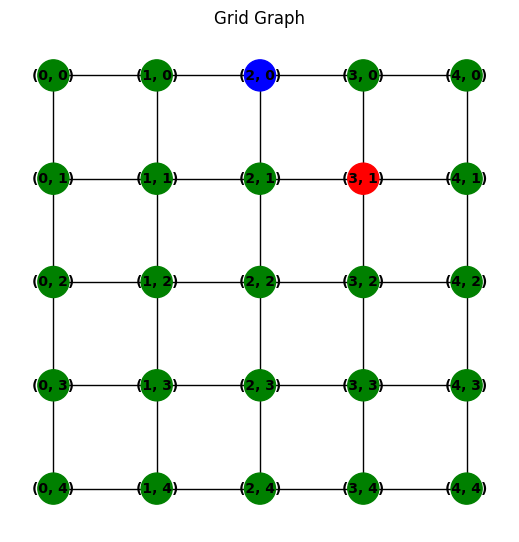

step 18 : -2.23606797749979
action : 1


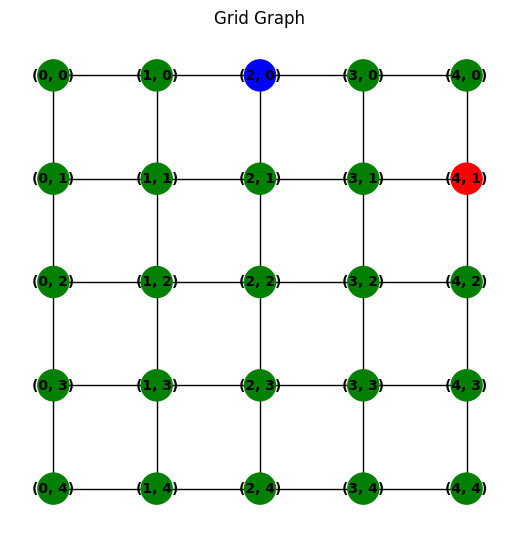

step 19 : -2.8284271247461903
action : 0


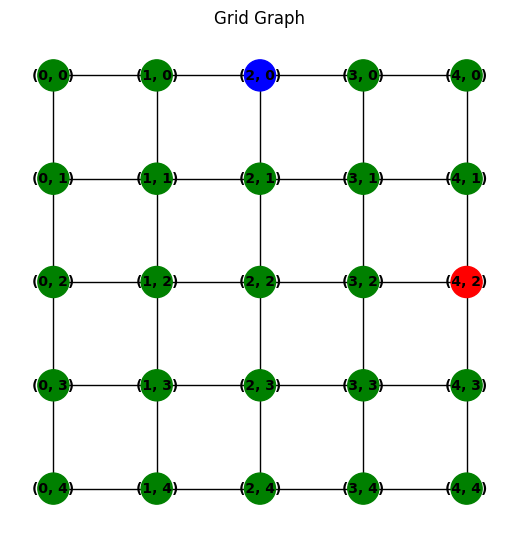

step 20 : -2.23606797749979
action : 2


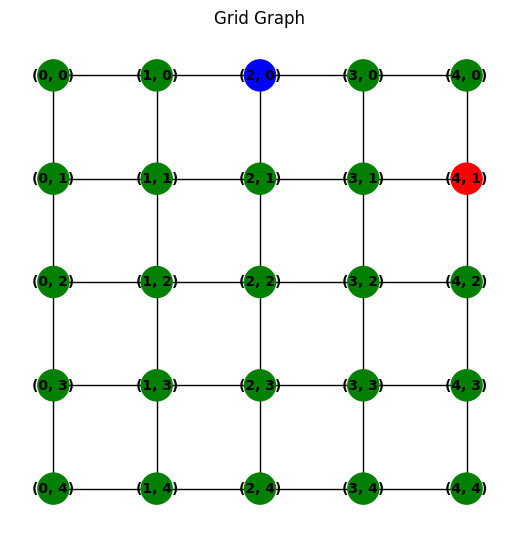

step 21 : -1.4142135623730951
action : 3


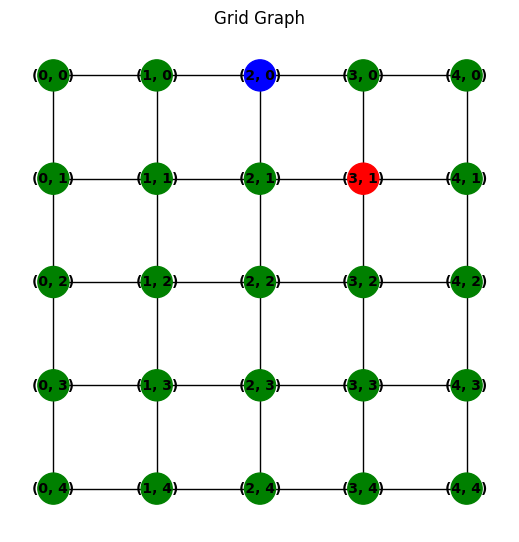

step 22 : -1.0
action : 3


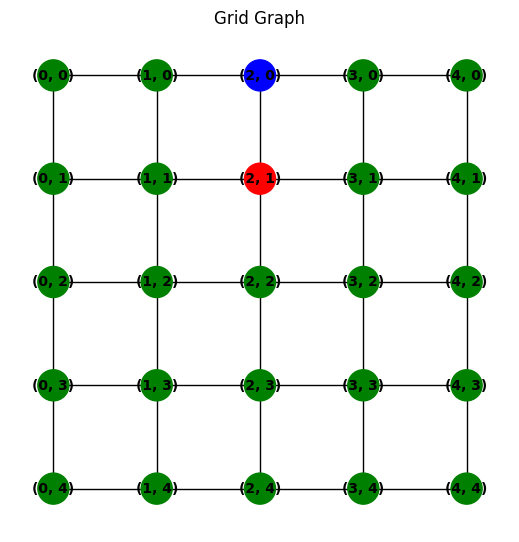

step 23 : -1.4142135623730951
action : 3


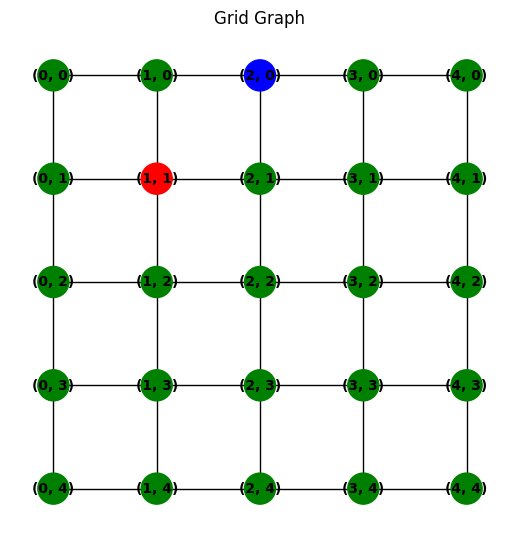

step 24 : -2.23606797749979
action : 0


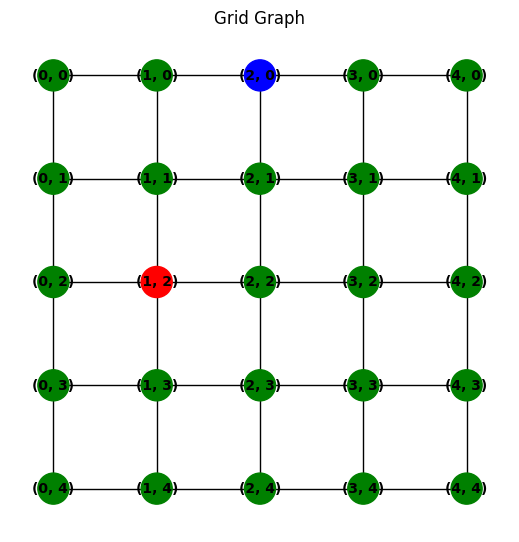

step 25 : -2.8284271247461903
action : 3


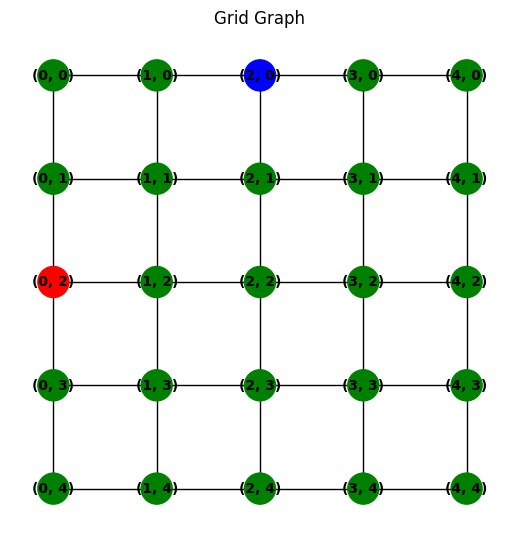

step 26 : -2.23606797749979
action : 2


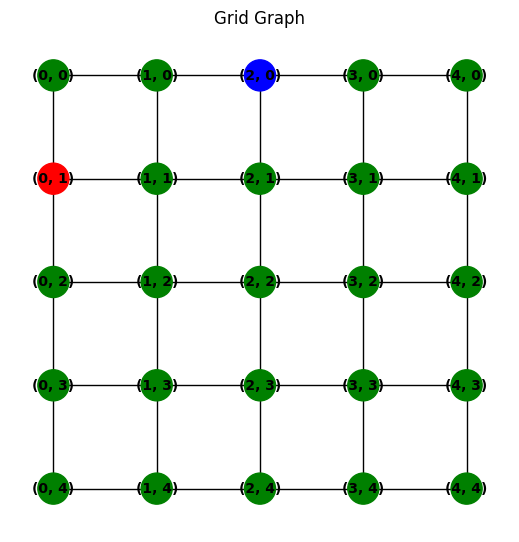

step 27 : -2.0
action : 2


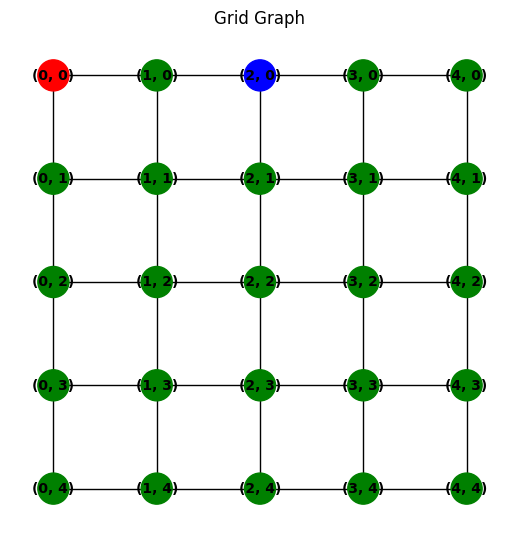

step 28 : -2.0
action : 2


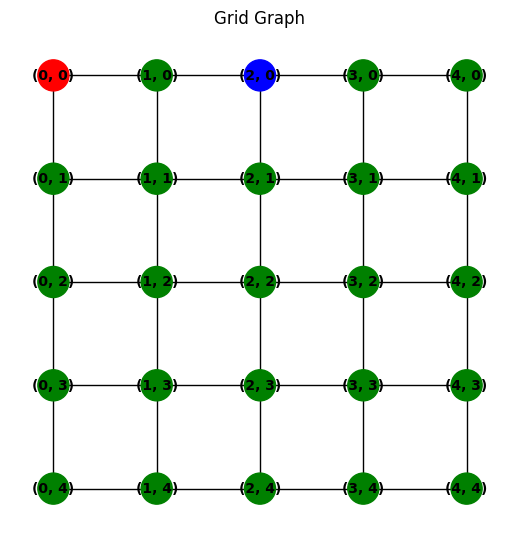

step 29 : -2.0
action : 3


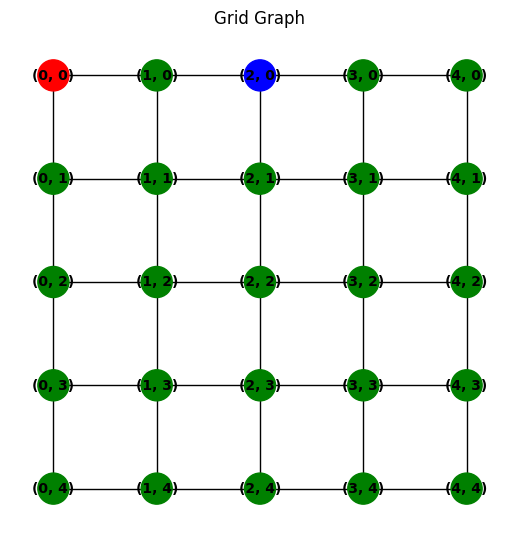

step 30 : -2.23606797749979
action : 0


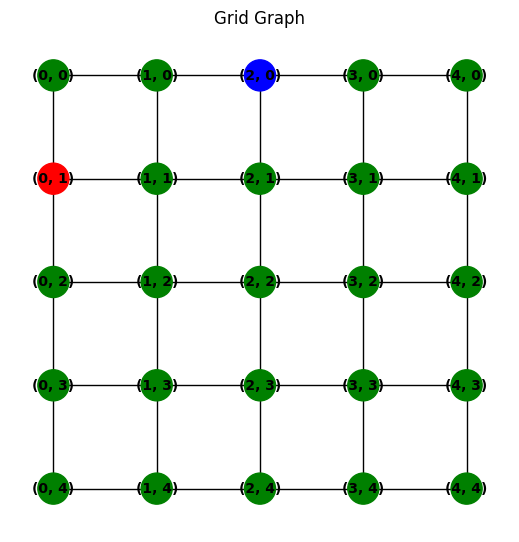

step 31 : -2.8284271247461903
action : 0


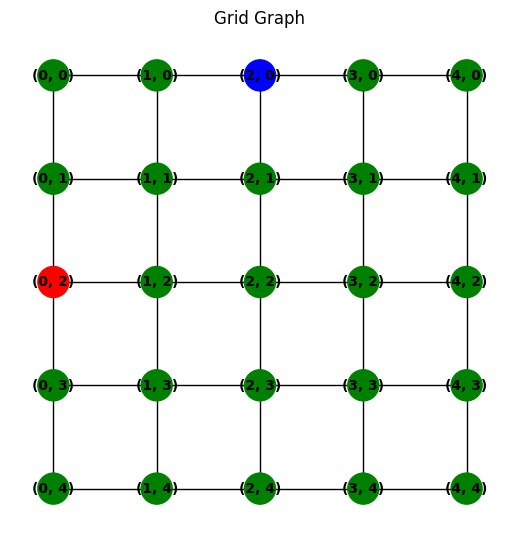

step 32 : -2.8284271247461903
action : 3


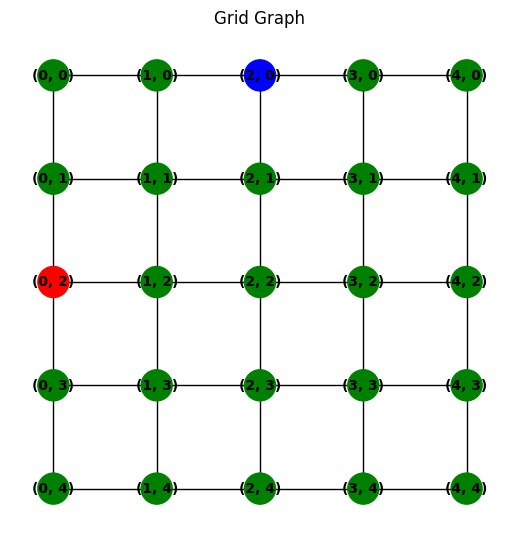

step 33 : -3.605551275463989
action : 0


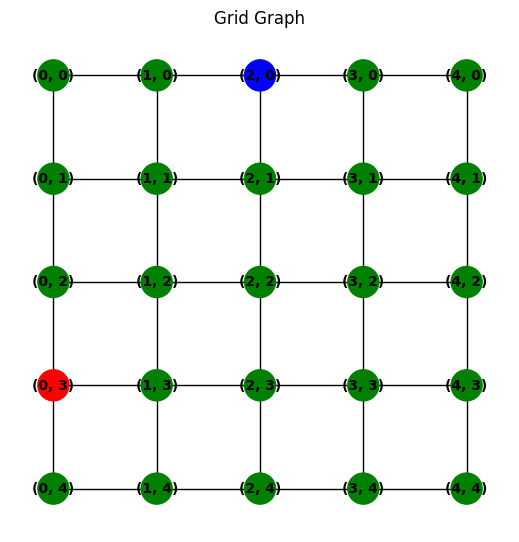

step 34 : -3.605551275463989
action : 3


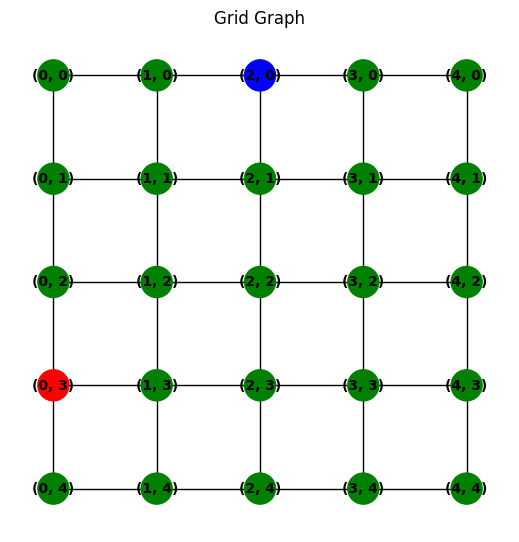

step 35 : -3.605551275463989
action : 3


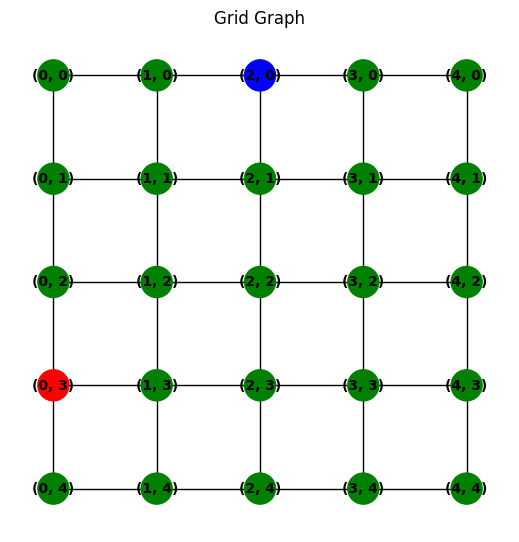

step 36 : -2.8284271247461903
action : 2


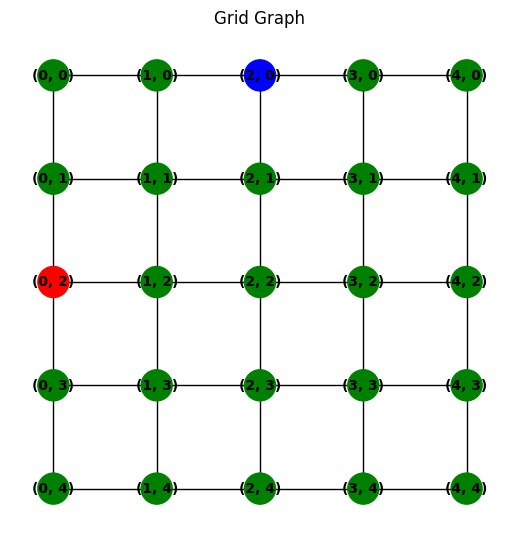

step 37 : -2.8284271247461903
action : 3


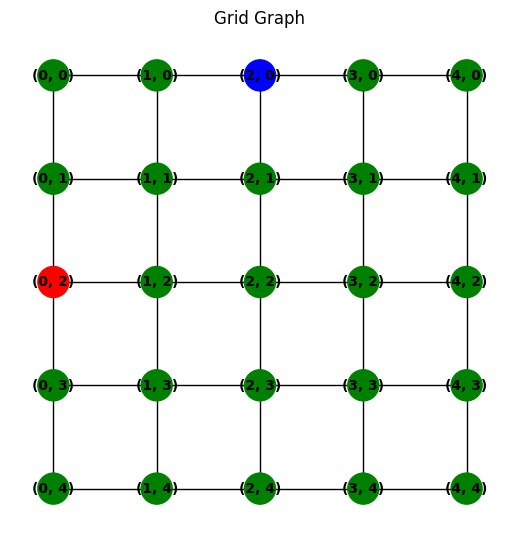

step 38 : -2.8284271247461903
action : 3


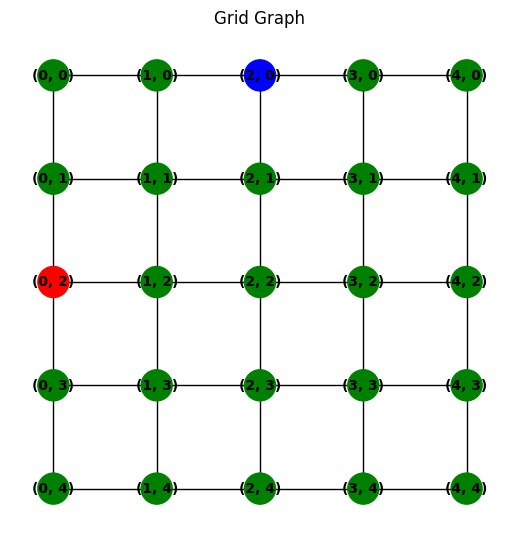

step 39 : -2.8284271247461903
action : 3


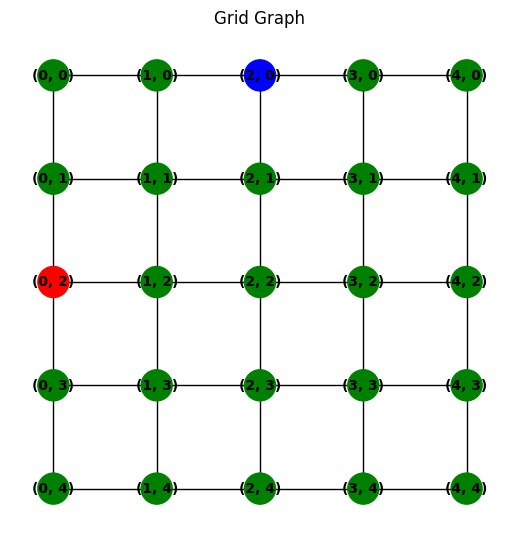

step 40 : -3.605551275463989
action : 0


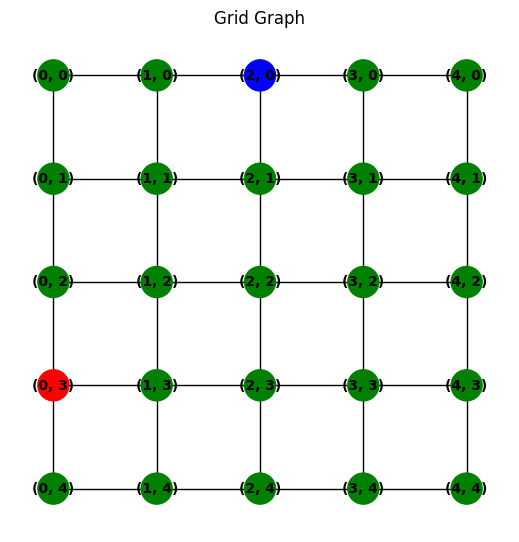

step 41 : -3.605551275463989
action : 3


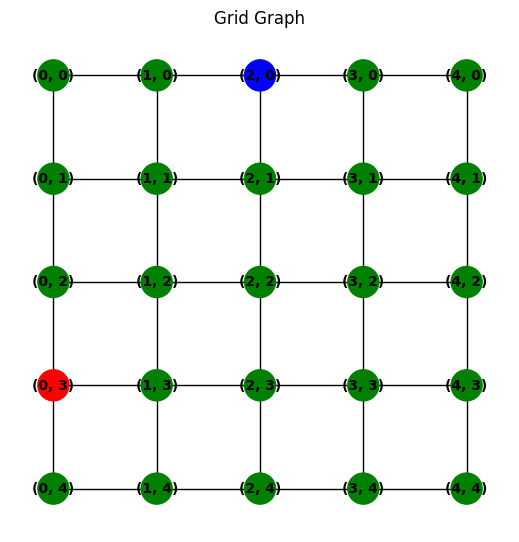

step 42 : -3.605551275463989
action : 3


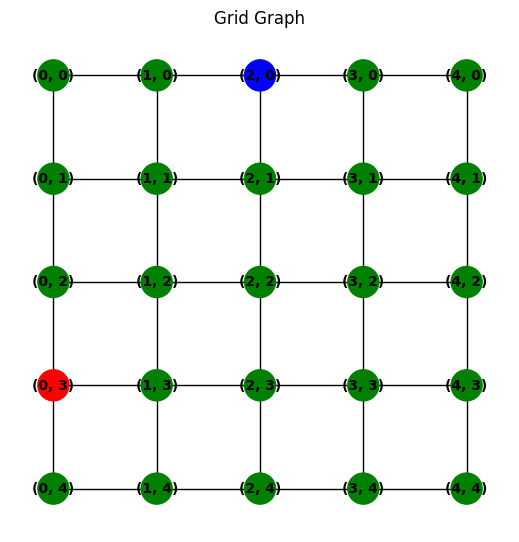

step 43 : -4.47213595499958
action : 0


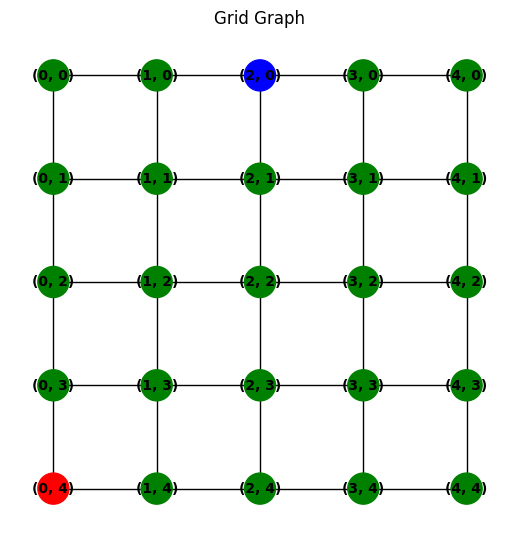

step 44 : -4.47213595499958
action : 3


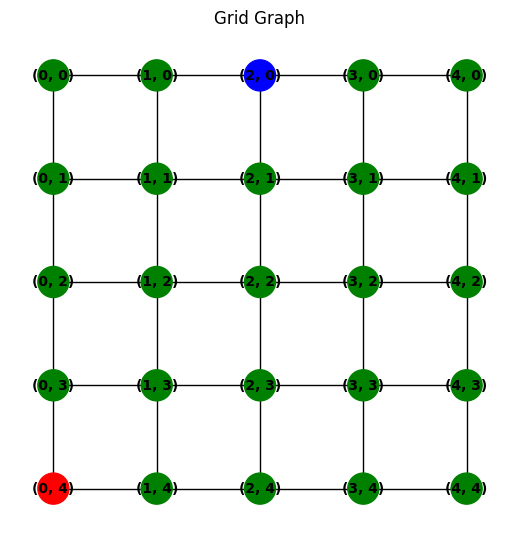

step 45 : -4.47213595499958
action : 3


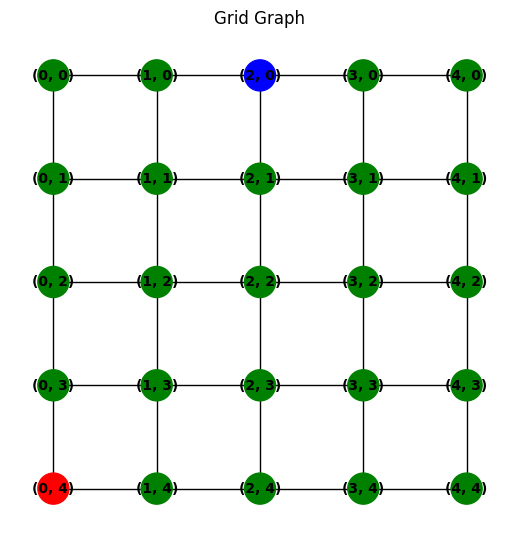

step 46 : -4.47213595499958
action : 3


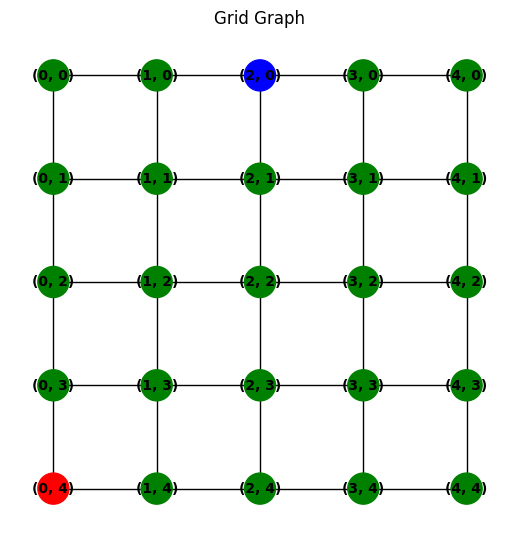

step 47 : -4.123105625617661
action : 1


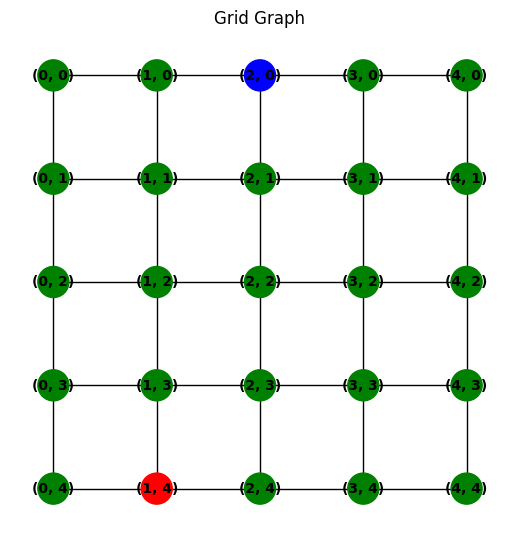

step 48 : -3.1622776601683795
action : 2


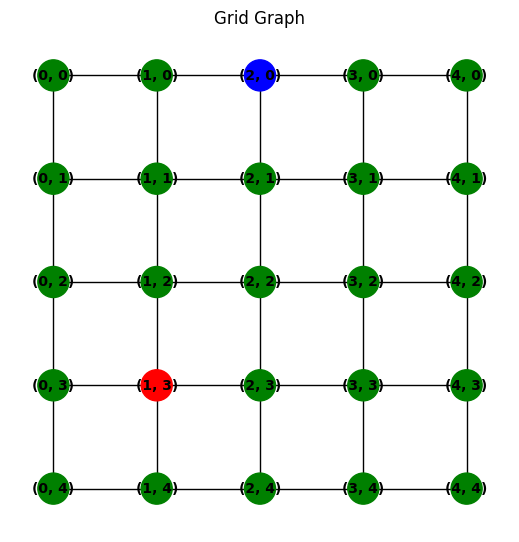

step 49 : -2.23606797749979
action : 2


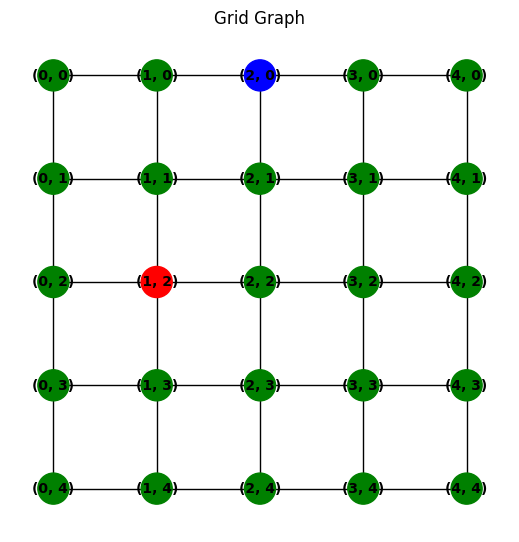

-2.23606797749979

In [ ]:
dqn.evaluate()

In [ ]:
print(dqn.q_network.transformer_encoder.multi_head_attention.head_num)

8
